## Data Visualisation 

## Objectives

* Meet Requirements for Business requirement One -

## Inputs

- inputs/cherry_leaves/train
- inputs/cherry_leaves/test
- inputs/cherry_leaves/test

## Outputs

- Image shape embeddings pickle file.
- Mean and variability of images per label plot.
- Plot to distinguish the contrast between healthy leaves and ones infected with powdery mildew.
- Generate code that satisfies business requirement 1 and can be used to build an image montage on the Streamlit dashboard.




# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Mildew-Detection/jupyter_notebooks'

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [5]:
current_dir = os.getcwd()
current_dir

'/workspaces/Mildew-Detection'

# Set up Input and Output Paths

Inputs

In [6]:
my_data_dir = 'inputs/cherry_leaves'
train_path = my_data_dir + '/train'
vald_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

Outputs

In [10]:
version = 'v1.6'

file_path = f'outputs/{version}'
version_file_path = os.path.join(current_dir, file_path)

if os.path.exists(version_file_path):
    print(f"version {version} already exists. Please create a new version")
    pass
else:
    os.makedirs(name=file_path)

Set Labels

In [14]:
labels = sorted(os.listdir(train_path))
print("Label for images are", labels)

Label for images are ['healthy', 'powdery_mildew']


---

# Data Visualization For Dataset

Image Shape Embeddings

Calculate the average size, being height and width in pixles, of images in the dataset

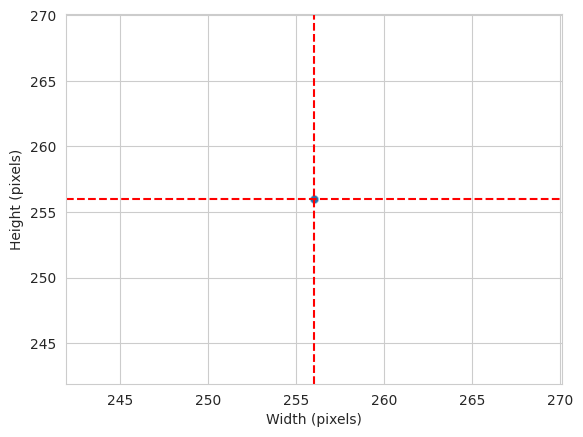

Width average: 256 
Height average: 256


In [17]:
sim1, sim2 = [], []
for Label in labels:
    for image_filename in os.listdir(train_path + '/' + Label):
        image = imread(train_path + '/' + Label + '/' + image_filename)
        s1, s2, colours = image.shape
        sim1.append(s1)
        sim2.append(s2)
        
sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=sim2, y=sim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
sim1_mean = int(np.array(sim1).mean())
sim2_mean = int(np.array(sim2).mean())
axes.axvline(x=sim1_mean, color='r', linestyle='--')
axes.axhline(y=sim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {sim2_mean} \nHeight average: {sim1_mean}")

In [18]:

image_shape = (sim1_mean, sim2_mean, 3)
image_shape

(256, 256, 3)

In [19]:
joblib.dump(value=image_shape,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1.6/image_shape.pkl']

### Mean and Variability of data per label

To load and preprocess image data from a directory into numpy arrays

In [20]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

  X, y = np.array([], dtype='int'), np.array([], dtype='object')
  labels = os.listdir(my_data_dir)

  for label in labels:
    counter = 0
    for image_filename in os.listdir(my_data_dir + '/' + label):
      
      if counter < n_images_per_label:
       
        img = image.load_img(my_data_dir + '/' + label +
                             '/' + image_filename, target_size=new_size)
                             
        
        if image.img_to_array(img).max() > 1:
          img_resized = image.img_to_array(img) / 255
        else:
          img_resized = image.img_to_array(img)
        
        
        X = np.append(X, img_resized).reshape(-1,
                                              new_size[0], new_size[1], img_resized.shape[2])
        y = np.append(y, label)
        counter += 1

  return X, y

Load the images shapes and labels into an array

In [21]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


Plot the mean and variability of images per label.

In [23]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
  
  for label_to_display in np.unique(y):
    sns.set_style("white")
    
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    arr = X[boolean_mask]
    
    
    avg_img = np.mean(arr, axis=0)
    std_img = np.std(arr, axis=0)

   
    print(f"==== Label {label_to_display} ====")
    print(f"Image Shape: {avg_img.shape}")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    axes[0].set_title(f"Average Image for label {label_to_display}")
    axes[0].imshow(avg_img, cmap='gray')
    axes[1].set_title(f"Variability image for label {label_to_display}")
    axes[1].imshow(std_img, cmap='gray')

    
    if save_image:
      plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                  bbox_inches='tight', dpi=150)
    else:
      plt.tight_layout()
      plt.show()
      print("\n")

In [ ]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12,5),save_image=True)

### Visualising between healthy and infected leaves

In [25]:
def subset_image_label(X, y, label_to_display):
  """
  Select all images from X that have the label label_to_display in y.
  """
  y = y.reshape(-1, 1, 1)
  boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
  df = X[boolean_mask]
  return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
  """
  Calculate the average image for two different labels in X, and plot the difference between them.
  """
  sns.set_style("white")

  if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
    print(
        f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
    return

 
  images_label = subset_image_label(X, y, label_1)
  label1_avg = np.mean(images_label, axis=0)

  
  images_label = subset_image_label(X, y, label_2)
  label2_avg = np.mean(images_label, axis=0)

  
  difference_mean = label1_avg - label2_avg
  difference_mean = label1_avg - label2_avg
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
  axes[0].imshow(label1_avg, cmap='gray')
  axes[0].set_title(f'Average {label_1}')
  axes[1].imshow(label2_avg, cmap='gray')
  axes[1].set_title(f'Average {label_2}')
  axes[2].imshow(difference_mean, cmap='gray')
  axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
  if save_image:
    plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
  else:
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


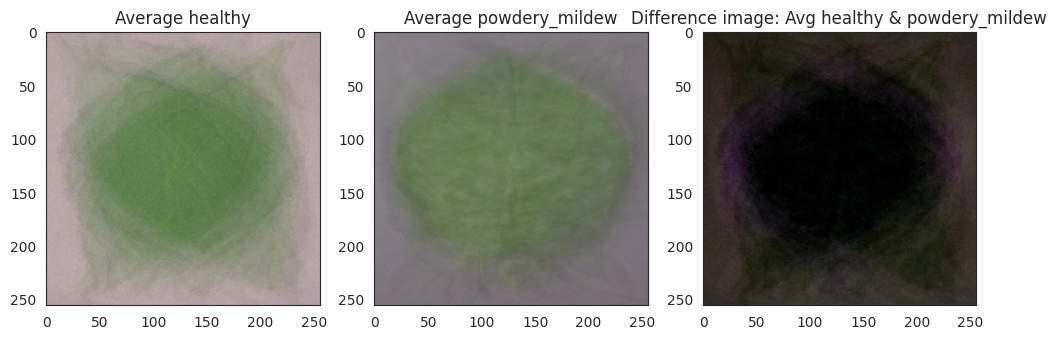

In [26]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='healthy', label_2='powdery_mildew',
                                        figsize=(12, 10),
                                        save_image=True
                                        )

#### Image Montage

Plot a montage of healthy and infected leaves

---

In [27]:
import itertools
import random

sns.set_style("white")

def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
  
  labels = os.listdir(dir_path)

  
  if label_to_display in labels:

   
    images_list = os.listdir(dir_path+'/' + label_to_display)
    if nrows * ncols < len(images_list):
      
      img_idx = random.sample(images_list, nrows * ncols)
    else:

      print(
          f"Decrease nrows or ncols to create your montage. \n"
          f"There are {len(images_list)} in your subset. "
          f"You requested a montage with {nrows * ncols} spaces")
      return

    
    list_cols = range(0, ncols)
    list_rows = range(0, nrows)
    plot_idx = list(itertools.product(list_rows, list_cols))
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for x in range(0, nrows*ncols):
      
      img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
      img_shape = img.shape
      axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
      axes[plot_idx[x][0], plot_idx[x][1]].set_title(
          f"Width {img_shape[1]}px x Height {img_shape[0]}px")
      axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
      axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
    
    plt.tight_layout()
    plt.show()

  else:
    
    print("The label you selected doesn't exist.")
    print(f"The existing options are: {labels}")

In [ ]:
for label in labels:
  print(label)
  image_montage(dir_path=train_path,
                label_to_display=label,
                nrows=3, ncols=3,
                figsize=(10, 15)
                )
  print("\n")